In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import copy

!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision


assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Used to load in the images
folder = './drive/My Drive/BYU/Boggle Project'
letter_dict_file = os.path.join(folder, 'letter_dict.pkl')
with open(letter_dict_file, 'rb') as file:
    letter_dict = pickle.load(file)


In [0]:
class RandomNoise(object):
    """
    A Custom Transform that adds random noise to a tensor image
    """
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [0]:
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Grayscale(),
                                      transforms.Resize(128), 
                                      transforms.RandomApply([transforms.RandomAffine(0,translate=(0.2,0.2))], p=0.5), 
                                      transforms.RandomApply([transforms.RandomAffine((-180,180))],p=0.5),
                                      transforms.ToTensor(),
                                      transforms.RandomApply([RandomNoise()], p=0.4),
                                      transforms.Normalize([0], [1])])

# image = letter_dict['f']
# image.shape
# transformations(image).squeeze(0)
# plt.imshow(transformations(image).squeeze(0), cmap='gray')
# plt.show()

In [0]:
# Create a Dataset with 5000 of each letter

# Define the transformation sequence of the letters
transformations = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Grayscale(),
                                      transforms.Resize(128), 
                                      transforms.RandomApply([transforms.RandomAffine(0,translate=(0.2,0.2))], p=0.5), 
                                      transforms.RandomApply([transforms.RandomAffine((-180,180))],p=0.5),
                                      transforms.ToTensor(),
                                      transforms.RandomApply([RandomNoise()], p=0.4),
                                      transforms.Normalize([0], [1])])

# Define the folder to hold the dataset
folder = './drive/My Drive/BYU/Boggle Project'
dataset_folder = os.path.join(folder, 'boggle_dataset')
if not os.path.exists(dataset_folder):
    os.mkdir(dataset_folder)
    print("Created Folder: {}".format(dataset_folder))

for key in letter_dict:
    # Define the folder path we're saving images to
    letter_folder_path = os.path.join(dataset_folder, key)

    # Create the folder if it doesn't exist.
    if not os.path.exists(letter_folder_path):
        os.mkdir(letter_folder_path)
        print("Created Folder: {}".format(letter_folder_path))

    # Make sure we only get up to 1500 for each letter. Don't redo work we don't have to, or have more than we need.
    num_letters = len(os.listdir(letter_folder_path))

    # print(key, num_letters)
    for i in range(num_letters, 1500):
        # Grab the image, apply the transformation, and save it to the appropriate image folder
        image = letter_dict[key]
        image = transformations(image)
        filename = 'image_{}_{}{}'.format(key.upper(), str(i+1).zfill(4), '.png')
        utils.save_image(image.squeeze(0), os.path.join(letter_folder_path,filename), format='png')
    print('Finished {} images'.format(key.upper()))


Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/t
Finished T images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/y
Finished Y images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/n
Finished N images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/u
Finished U images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/r
Finished R images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/q
Finished Q images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/a
Finished A images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/k
Finished K images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/i
Finished I images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_dataset/b
Finished B images
Created Folder: ./drive/My Drive/BYU/Boggle Project/boggle_data

In [0]:
# Key Order:
# ['t', 'y', 'n', 'u', 'r', 'q', 'a', 'k', 'i', 'b', 'd', 'o', 'g', 'z', 'h', 'j', 's', 'w', 'v', 'f', 'p', 'l', 'x', 'e', 'm', 'c']

In [0]:
# Define our Boggle Dataset class
class BoggleDataset(Dataset):
    def __init__(self, root='./drive/My Drive/BYU/Boggle Project', size=128, train=True):
        # Initialize input variables, load the full dataset
        self.__dict__.update(locals())
        dataset_folder = os.path.join(self.root, 'boggle_dataset')
        self.transformations = transforms.Compose([transforms.Resize(self.size), transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        self.full_dataset = torchvision.datasets.ImageFolder(root=dataset_folder, transform=self.transformations)

        # Split the data into train and test 
        train_X, test_X, train_y, test_y = train_test_split(range(len(self.full_dataset)), self.full_dataset.targets, train_size=0.7, test_size=0.3, random_state=9)
        if self.train: self.dataset = torch.utils.data.Subset(self.full_dataset,train_X) 
        else: self.dataset = torch.utils.data.Subset(self.full_dataset,test_X)

    def __getitem__(self,index):
        img = self.dataset[index][0]
        label = self.dataset[index][1] # Labels are 0-25, which correspond to A-Z.
        return img,label
  
    def __len__(self):
        return len(self.dataset)

In [0]:
from sklearn.model_selection import train_test_split
dataset = BoggleDataset()

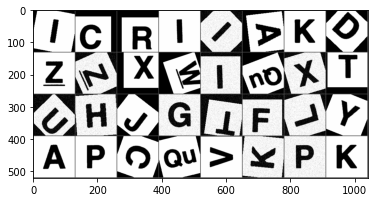

In [6]:
from torchvision import utils as vutils

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

TrainLoader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers = 16)
xbatch, _ = iter(TrainLoader).next()

show_imgs(xbatch)

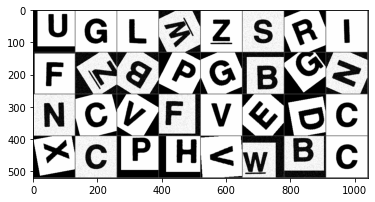

In [7]:
xbatch, _ = iter(TrainLoader).next()

show_imgs(xbatch)